In [1]:
from dirac import DataBase

Start the Spark cluster with 32 executors and initialize database.

In [2]:
db = DataBase(conf={"spark.executor.instances" : 32})

Status,Pod Name,Message
Running,pyspark-1567589249-stevenstetzler-spark-exec-1,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-10,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-11,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-12,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-13,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-14,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-15,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-16,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-17,Started container
Running,pyspark-1567589249-stevenstetzler-spark-exec-18,Started container


Load the Gaia DR2 data

In [3]:
import pyspark.sql.functions as sparkfunc

catalogs = db.get_catalogs()

gaia_ = catalogs.load("gaiadr2")
gaia = gaia_.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia_['source_id']/34359738368))

Create a user-defined function that will act on rows of the Gaia data.

In [4]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits

def healpix_hist(input_df, NSIDE=64, groupby=[],
                 agg={"*": "count"}, returnDf=False):
    from pyspark.sql.functions import floor as FLOOR, col as COL, lit, shiftRight

    order0 = 12
    order  = hp.nside2order(NSIDE)
    shr    = 2*(order0 - order)

    # construct query
    df = input_df.withColumn('hpix__', shiftRight('hpix12', shr))
    gbcols = ('hpix__', )
    for axspec in groupby:
        if not isinstance(axspec, str):
            (col, c0, c1, dc) = axspec
            df = ( df
                .where((lit(c0) < COL(col)) & (COL(col) < lit(c1)))
                .withColumn(col + '_bin__', FLOOR((COL(col) - lit(c0)) / lit(dc)) * lit(dc) + lit(c0) )
                 )
            gbcols += ( col + '_bin__', )
        else:
            gbcols += ( axspec, )
    df = df.groupBy(*gbcols)

    # execute aggregation
    df = df.agg(agg)

    # fetch result
    df = df.toPandas()
    if returnDf:
        return df

    # repack the result into maps
    # This results line is slightly dangerous, because some aggregate functions are purely aliases.
    # E.g., mean(x) gets returned as a column avg(x).
    results = [ f"{v}({k})" if k != "*" else f"{v}(1)" for k, v in agg.items() ]    # Result columns
    def _create_map(df):
        maps = dict()
        for val in results:
            map_ = np.zeros(hp.nside2npix(NSIDE))
            # I think this line throws an error if there are no rows in the result
            map_[df.hpix__.values] = df[val].values 
            maps[val] = [ map_ ]
        return pd.DataFrame(data=maps)

    idxcols = list(gbcols[1:])
    if len(idxcols) == 0:
        ret = _create_map(df)
        assert(len(ret) == 1)
        if not returnDf:
            # convert to tuple, or scalar
            ret = tuple(ret[name].values[0] for name in results)
            if len(ret) == 1:
                ret = ret[0]
    else:
        ret = df.groupby(idxcols).apply(_create_map)
        ret.index = ret.index.droplevel(-1)
        ret.index.rename([ name.split("_bin__")[0] for name in ret.index.names ], inplace=True)
        if "count(1)" in ret:
                    ret = ret.rename(columns={'count(1)': 'count'})
        if not returnDf:
            if len(ret.columns) == 1:
                ret = ret.iloc[:, 0]
    return ret



def bin_column(start, stop, bins, data):
    bin_size = (stop - start)/bins
    return sparkfunc.floor((data - start)/bin_size)

Apply this function to the Gaia data and time the function execution.

In [5]:
%%time

map_ = healpix_hist(gaia.where(gaia['dup'] == 0), NSIDE=512)

/opt/conda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


CPU times: user 146 ms, sys: 75.9 ms, total: 221 ms
Wall time: 1min 24s


Plot the results!

In [6]:
%matplotlib inline

import matplotlib

In [7]:
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = [8, 6]

/opt/conda/lib/python3.7/site-packages/healpy/projaxes.py:988: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/conda/lib/python3.7/site-packages/healpy/projaxes.py:958: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


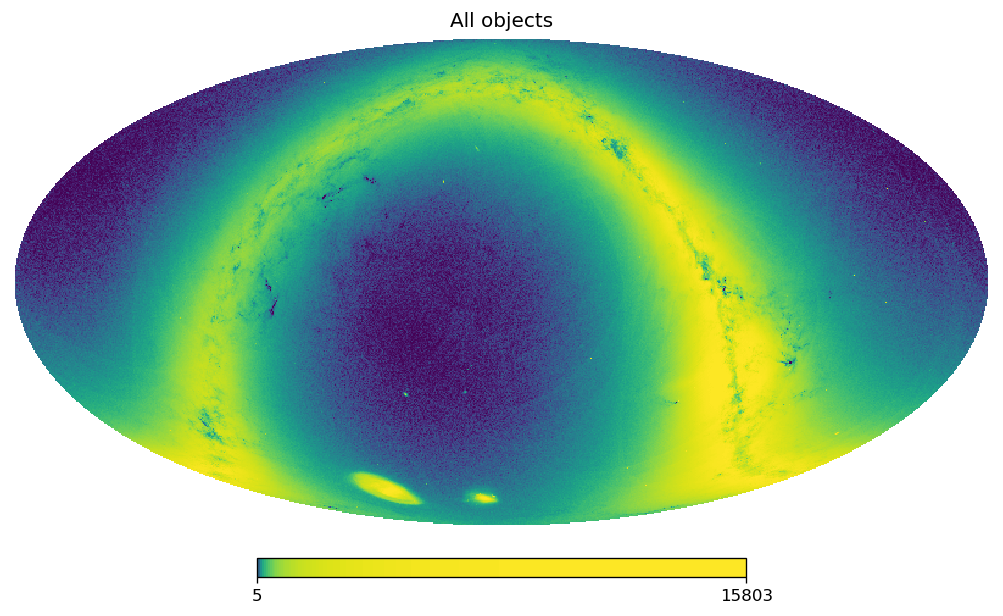

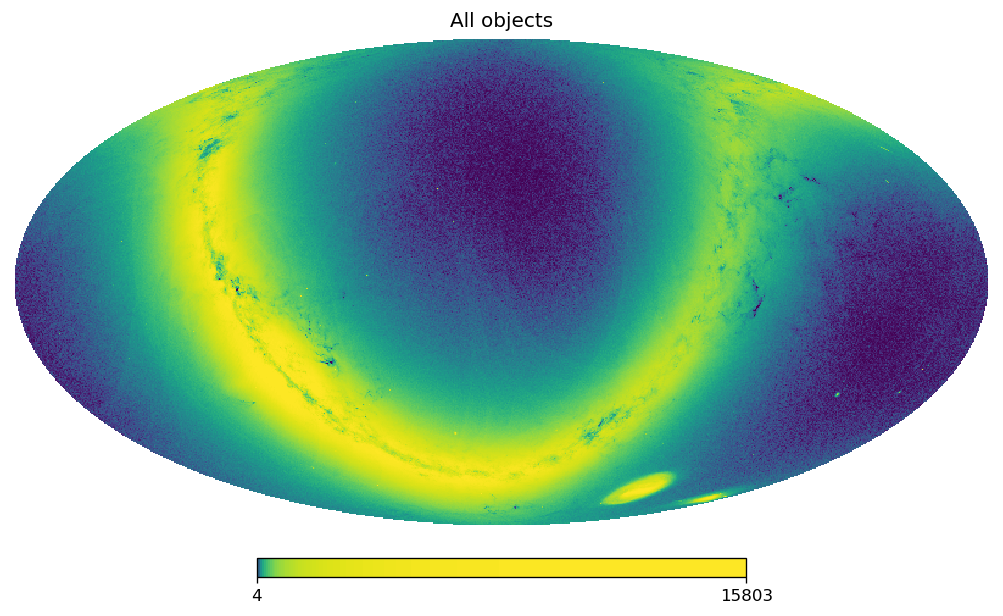

In [8]:
hp.mollview(map_, title="All objects", rot=(0, 0, 0), nest=True, norm='hist')
plt.show()
hp.mollview(map_, title="All objects", rot=(180, 0, 0), nest=True, norm='hist')